In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [3]:

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [222]:
class Value:
    
    def __init__ (self, data, _children=(), _op="", label=""):
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda: None
        self.data = data
        self._op = _op
        self.label=label
    
    def __repr__(self):
        return f"Value({self.data})"
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __rsub__(self, other):
        return self-other
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, (self, other), _op="+")
        
        def _backward():
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad
        result._backward = _backward
        
        return result
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data * other.data, (self, other), _op="*")
        
        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
            
        result._backward = _backward
            
        return result
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        result = Value(self.data**other, (self, ), f'**{other}')
                       
        def _backward():
            self.grad += (other * (self.data**(other-1))) * result.grad
                        
        result._backward = _backward
        return result
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        result = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * result.grad
        result._backward = _backward
            
        return result
    
    def relu(self):
        
        x = max(0, self.data)
        result = Value(x, (self, ), 'relu')
        
        def _backward():
            self.grad += result.grad if x > 0 else 0
        result._backward = _backward
        
        return result
    
    def exp(self):
        x = self.data
        result = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += result.data * result.grad
        result._backward = _backward
                         
        return result
    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
                
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [218]:
class Neuron:
    
    def __init__(self, nin): #num inputs
        self.w = [Value(random.uniform(-1, 1), label='w') for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1), label='b')
        
    def __call__(self, x):
        act = sum((wi * wx for wi, wx in zip(self.w, x)), self.b)
        result = act.tanh()
        return result
    
    def parameters(self):
        return [self.b] + self.w
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outputs = [n(x) for n in self.neurons]
        return outputs[0] if len(outputs) ==1 else outputs
    
    def parameters(self):
        return [p for neurons in self.neurons for p in neurons.parameters()]
    
class MLP:
    
    def __init__(self, _layers):
        assert all(isinstance(item, int) for item in _layers)
        self.layers = [Layer(_layers[i], _layers[i+1]) for i in range(len(_layers)-1)]
    
    def __call__(self, x):
        assert len(x) == len(self.layers)
        output = x
        
        for layer in self.layers:
            output = layer(output)
        
        return output
    
    def parameters(self):
        
        return [p for layer in self.layers for p in layer.parameters()]
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0
            
    def step(self, learning_rate):
        
        for p in self.parameters():
            p.grad += -p.grad * learning_rate
            



In [206]:
def RMSE(ypred, ytrue):
    return sum((yp-yt)**2 for yp, yt in zip(ypred, ytrue))
        

In [223]:
model = MLP([3, 4, 4, 1])

xs = [
    [2.0, 3.0, -1],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1, -1, -1, 1]

for i in range(500):
    model.zero_grad()
    ypred = [model(x) for x in xs]
    loss = RMSE(ys, ypred)
    loss.backward()
    model.step(.05)
    print(loss)s
    


Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202

Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202888632101703)
Value(3.0202

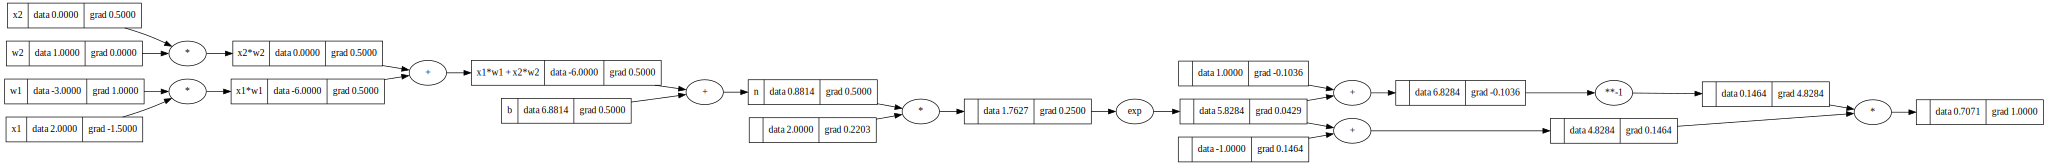

In [190]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1) / (e+1)


o.backward()
draw_dot(o)



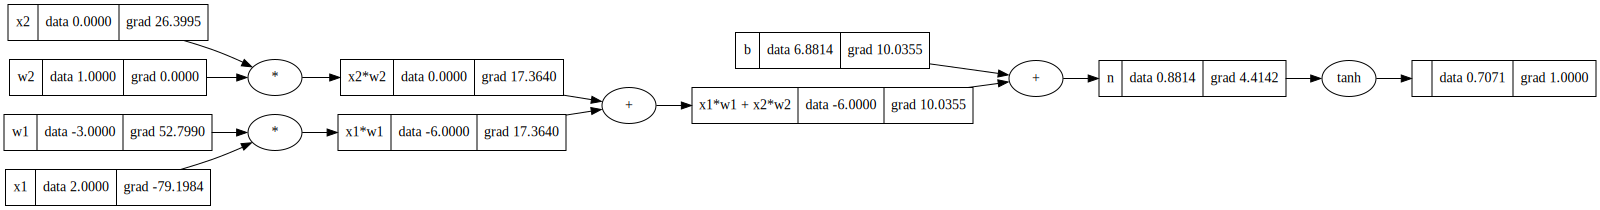

In [142]:
o = n.tanh()
o.backward()
draw_dot(o)

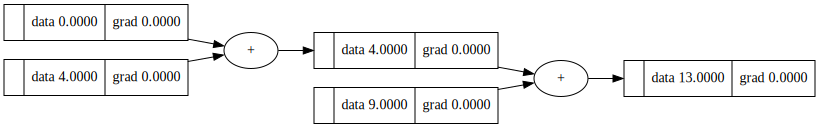

In [76]:
cd = Value(4.0)
ab = Value(9.0)
jk = [cd, ab]
kk = sum(jk)
draw_dot(kk)